In [ ]:
!pip install together matplotlib seaborn pandas openpyxl python-docx pdfplumber pytesseract pillow PyMuPDF

import os
import fitz  # PyMuPDF
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pdfplumber
import docx
import pytesseract
from PIL import Image
from IPython.display import display, Markdown
import json
import requests
import mimetypes
import re

In [ ]:
%matplotlib inline

# Together API Setup
TOGETHER_API_KEY = "your-api-key-here"  # API key
TOGETHER_MODEL = "meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8"

client = Together(api_key=TOGETHER_API_KEY)

# Secure environment for executing generated chart code
'''safe_globals = {s
    "__builtins__": {},
    "plt": plt,
    "sns": sns,
    "pd": pd,
    "range": range,
    "len": len,
    "list": list

}'''

safe_globals = {
    "__builtins__": {
        "len": len,
        "range": range,
        "min": min,
        "max": max,
        "__import__": __import__,  # Enable import statements
    },
    "plt": plt,
    "sns": sns,
    "pd": pd,
}

# Execute generated code safely
def execute_generated_code(code):
    try:
        exec(code, safe_globals)
    except Exception as e:
        print(f"⚠️ Error executing generated code: {e}")

# Query Llama with SYSTEM PROMPT for smart chart + data responses

def query_llama(prompt, history=[]):
    messages = []

    # Add system prompt first
    messages.append({
        "role": "system",
        "content": """You are a highly skilled data analyst agent. You help users analyze uploaded documents including CSV, Excel, text, Word, PDFs, and images with OCR. Only generate Python code if the question explicitly asks for a chart, graph, plot, or data visualization and do not generate code otherwise.

If the query involves visualization (e.g., bar chart, line graph, pie chart), respond with ready to use copy-paste, clean Python code using pandas, matplotlib, or seaborn — without explaining the code and anything related to it. **If you generate code for a visualization, start your response with the tag `[VIZ]` on a new line before any other content or code.**

If the input is tabular data, use proper column names in your responses and examples. If the input is a document, refer to its content logically.

Your responses should always assume you have access to data as described by the user or passed in system context. Always behave as a professional assistant helping with data analysis, document understanding.
"""
    })

    # Add history (turns) if available
    for i in range(0, len(history), 2):
        messages.append({"role": "user", "content": history[i][3:]})
        messages.append({"role": "assistant", "content": history[i + 1][3:]})

    # Add current prompt
    messages.append({"role": "user", "content": prompt})

    # Call Together API (streaming is False to capture full output)
    response = client.chat.completions.create(
        model=TOGETHER_MODEL,
        messages=messages,
        temperature=0.3,
        max_tokens=1024,
        stream=False
    )

    return response.choices[0].message.content.strip()

# File detection
def get_file_type(filepath):
    mime_type, _ = mimetypes.guess_type(filepath)
    if mime_type:
        if 'pdf' in mime_type:
            return 'pdf'
        elif 'image' in mime_type:
            return 'image'
        elif 'word' in mime_type or filepath.endswith('.docx'):
            return 'docx'
        elif filepath.endswith('.txt'):
            return 'text'
        elif filepath.endswith('.csv'):
            return 'csv'
        elif filepath.endswith('.xlsx'):
            return 'excel'
    return 'unsupported'

# File content extraction
def extract_content(filepath):
    filetype = get_file_type(filepath)
    if filetype == "text":
        with open(filepath, "r", encoding="utf-8") as f:
            return f.read()
    elif filetype == "docx":
        doc = docx.Document(filepath)
        return "\n".join([p.text for p in doc.paragraphs])
    elif filetype == "pdf":
        with pdfplumber.open(filepath) as pdf:
            return "\n".join([page.extract_text() for page in pdf.pages if page.extract_text()])
    elif filetype == "image":
        img = Image.open(filepath)
        return pytesseract.image_to_string(img)
    elif filetype == "csv":
        return pd.read_csv(filepath)
    elif filetype == "excel":
        return pd.read_excel(filepath)
    return "Unsupported file type."

# Answer questions
chat_history = []

def ask_question(question, content, history=[]):
    if isinstance(content, pd.DataFrame):
        sample_data = content.head(3).to_markdown()
        cols = ", ".join(content.columns)
        context = f"""You are a data analyst.
Data Columns: {cols}
Sample Data:
{sample_data}
Answer this question: {question}"""
    else:
        context = f"""Here's a document:
{content[:2000]}
Answer: {question}"""

    # query_llama handles both answering and indicating visualization
    response = query_llama(context) # Pass the full context to query_llama
    history.append(f"Q: {question}")
    # Store the full response including the potential VIZ tag in history
    history.append(f"A: {response}")
    return response


def extract_code_blocks(text):
    code_blocks = re.findall(r"```(.*?)```", text, re.DOTALL)
    # Removes language identifier like 'python' if present
    cleaned_blocks = []
    for block in code_blocks:
        lines = block.strip().split('\n')
        if lines and lines[0].strip().lower() == 'python':
            lines = lines[1:]  # Remove the first line
        cleaned_blocks.append('\n'.join(lines))
    return cleaned_blocks

# Modified chat_loop to check for [VIZ] tag
def chat_loop(content):
    print("Start asking questions (type 'exit' to quit):")
    while True:
        q = input("You: ")
        if q.lower() == "exit":
            break

        # Now ask_question directly calls query_llama and gets the response
        # The response will include [VIZ] if a visualization is generated
        a = ask_question(q, content, chat_history)
        print(f"🧠 Agent: {a}\n")

        # Check if the response starts with the visualization tag
        if a.strip().lower().startswith("[viz]"):
            # Remove the tag before extracting code
            response_without_tag = a.strip()[5:].strip()
            code_blocks = extract_code_blocks(response_without_tag)
            for code in code_blocks:
                print("📊 Executing visualization code...")
                try:
                    # Use the existing execute_generated_code function
                    execute_generated_code(code)
                except Exception as e:
                    print(f"⚠️ Error executing generated code: {e}")


ICT
“2016 marks the year when
the international community is
embarking on the implementation
of the 17 Sustainable Development
Goals (SDGs) and their 169 targets.
FACTS AND The International Telecommunication
Union, given the tremendous
development of ICTs, has a key role
FIGURES
to play in facilitating their attainment.
Our new data show that in 2016,
2016 over two-thirds of the population
lives within an area covered by a Brahima Sanou,
mobile broadband network and that Director of the ITU
Telecommunication
ICT services continue to become
Development Bureau
more aff ordable. Despite these
unprecedented opportunities,
more than half of all people are not
yet using the Internet and large
diff erences in terms of broadband
speeds and quality exist. ITU data
inform public and private-sector
decision makers, and help us
accomplish our mission: to make use
of the full potential of ICTs for the
timely achievement of the SDGs.”
Mobile network coverage and evolving technologies
Source: ITU.
N

Start asking questions (type 'exit' to quit):
You: whats the data about
🧠 Agent: The document appears to be a report from the International Telecommunication Union (ITU) discussing the state of Information and Communication Technologies (ICTs) in relation to the Sustainable Development Goals (SDGs). The data presented in the document is about:

1. **Mobile network coverage**: 
   - 95% of the global population lives in an area covered by a mobile-cellular network.
   - 84% of the global population is covered by mobile-broadband networks (3G or above), but this figure drops to 67% for the rural population.
   - LTE networks cover almost 4 billion people (53% of the global population).

2. **Internet usage**:
   - More than half of the world's population is not using the Internet.
   - By the end of 2016, 3.9 billion people (53% of the world's population) were not using the Internet.

3. **Regional breakdown of Internet non-usage**:
   - The percentage of individuals not using the Intern

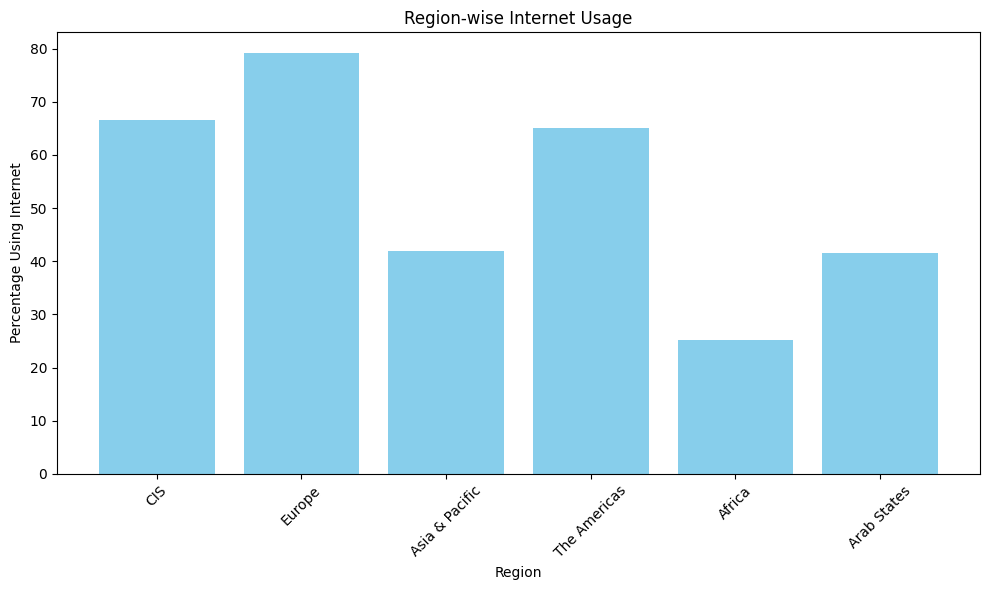

You: exit


In [ ]:
# Upload file path here
uploaded_file = "/content/ICTFactsFigures2016.pdf"  # Change this to your file path
content = extract_content(uploaded_file)

# Preview content
if isinstance(content, pd.DataFrame):
    display(content.head())
else:
    display(Markdown(content[:1000]))

# Start chat
chat_loop(content)